<a href="https://colab.research.google.com/github/Igor-Tukh/deep-unsupervised-learning-hse/blob/hw02/hw02_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Deep Unsupervised Learning course, HSE, fall-winter 2019**
## **HW 02**
#### **Student: Igor Tukh**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
def visualize_data(x, y):
  plt.scatter(x[:, 0], x[:, 1], 1, y)
  plt.show()

In [0]:
x, y = sample_data()

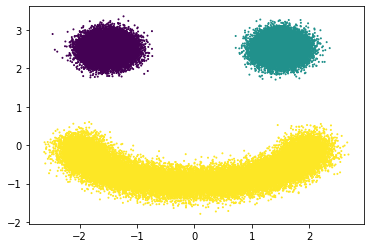

In [72]:
visualize_data(x, y)

In [0]:
np.random.seed(23923)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [0]:
x_test = torch.from_numpy(x_test)
x_train = torch.from_numpy(x_train)
y_test = torch.from_numpy(y_test)
y_train = torch.from_numpy(y_train)

In [75]:
print(f'Train dataset size: {x_train.shape[0]}, test dataset size: {x_test.shape[0]}')

Train dataset size: 79999, test dataset size: 20000


In [0]:
class Flow(nn.Module):
  def __init__(self, k=6, hidden_size=100):
    super(Flow, self).__init__()

    self.k = k
    self.hidden_size = hidden_size

    self.pi_x1 = nn.Parameter(torch.randn(k, requires_grad=True))
    self.pi_x1_softmax = nn.Softmax(dim=-1)
    self.mu_x1 = nn.Parameter(torch.randn(k, requires_grad=True))
    self.sigma_x1 = nn.Parameter(torch.randn(k, requires_grad=True))

    self.pi_x2 = nn.Sequential(nn.Linear(1, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, k),
                               nn.Softmax(dim = -1))
    self.mu_x2 = nn.Sequential(nn.Linear(1, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, k))
    self.sigma_x2 = nn.Sequential(nn.Linear(1, hidden_size),
                                  nn.ReLU(),
                                  nn.Linear(hidden_size, k))

  def x1_params(self, x): 
    pi_x1 = self.pi_x1_softmax(self.pi_x1)
    mu_x1 = self.mu_x1
    sigma_x1 = torch.abs(self.sigma_x1)

    return pi_x1, mu_x1, sigma_x1

  def x2_params(self, x):
    pi_x2 = self.pi_x2(x)
    mu_x2 = self.mu_x2(x)
    sigma_x2 = torch.abs(self.sigma_x2(x))

    return pi_x2, mu_x2, sigma_x2

  def to_latent(self, x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    self.shape = x.shape[0]

    z1 = torch.zeros(self.shape)
    z2 = torch.zeros(self.shape)

    pi_x1, mu_x1, sigma_x1 = self.x1_params(x1.view(-1, 1))
    pi_x2, mu_x2, sigma_x2 = self.x2_params(x1.view(-1, 1))

    for i in range(self.k):
      z1 += pi_x1[i] * torch.distributions.Normal(mu_x1[i], sigma_x1[i]).cdf(x1)
      z2 += pi_x2[:, i] * torch.distributions.Normal(mu_x2[:, i], sigma_x2[:, i]).cdf(x2)
    
    return z1, z2    

  def forward(self, x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    self.shape = x.shape[0]

    prob_x1 = torch.zeros(self.shape)
    prob_x2 = torch.zeros(self.shape)

    pi_x1, mu_x1, sigma_x1 = self.x1_params(x1.view(-1, 1))
    pi_x2, mu_x2, sigma_x2 = self.x2_params(x1.view(-1, 1))

    for i in range(self.k):
      prob_x1 += pi_x1[i] * torch.distributions.Normal(mu_x1[i], sigma_x1[i]).log_prob(x1).exp()
      prob_x2 += pi_x2[:, i] * torch.distributions.Normal(mu_x2[:, i], sigma_x2[:, i]).log_prob(x2).exp()
    
    return prob_x1 * prob_x2

In [0]:
def get_loss(y):
  return -torch.mean(torch.log(y)) / 2

In [0]:
def plot_losses(train_losses, test_losses):
  plt.title('Losses')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  epoches = range(0, len(train_losses))
  plt.plot(epoches, train_losses, label='train loss')
  plt.plot(epoches, test_losses, label='test loss')
  plt.legend()
  plt.show()

In [0]:
def train(model, train, test, lossf=get_loss, epoches_number=20, lr=1e-3, batch_size=100):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train_batches = torch.utils.data.DataLoader(train, batch_size=batch_size)
  test_batches = torch.utils.data.DataLoader(test, batch_size=batch_size)

  train_losses = []
  test_losses = []

  for epoch in range(epoches_number):
    losses = []
    for batch in train_batches:
      optimizer.zero_grad()
      output = model(batch.float())
      loss = lossf(output)
      loss.backward()
      optimizer.step()
      losses.append(loss.detach().numpy())
    train_losses.append(np.mean(np.array(losses)))

    with torch.no_grad():
      losses = []
      for batch in test_batches:
        output = model(batch.float())
        loss = lossf(output)
        losses.append(loss.detach().numpy())
      test_losses.append(np.mean(np.array(losses)))
    
    if epoch % 4 == 0 or epoch == epoches_number - 1:
      print(f'Epoch: {epoch}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}')
    
  plot_losses(train_losses, test_losses)

Epoch: 0, train loss: 1.2987661361694336, test loss: 0.9060156941413879
Epoch: 4, train loss: 0.6834490895271301, test loss: 0.6816921234130859
Epoch: 8, train loss: 0.6826269030570984, test loss: 0.6791804432868958
Epoch: 12, train loss: 0.6802453398704529, test loss: 0.6795362234115601
Epoch: 16, train loss: 0.6784709095954895, test loss: 0.677584707736969
Epoch: 19, train loss: 0.6774572730064392, test loss: 0.6775581240653992


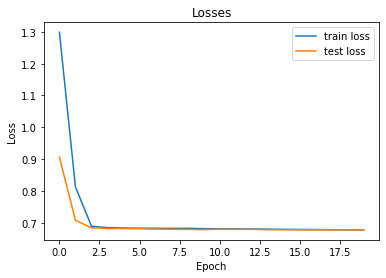

Flow(
  (pi_x1_softmax): Softmax(dim=-1)
  (pi_x2): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=6, bias=True)
    (3): Softmax(dim=-1)
  )
  (mu_x2): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
  (sigma_x2): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
)

In [147]:
model = Flow().float()
train(model, x_train, x_test)

In [158]:
one_dim = np.linspace(-4, 4, 1000)
two_dim = np.array([[x, y] for x in one_dim for y in one_dim])
two_dim[:3]

(1000000, 2)

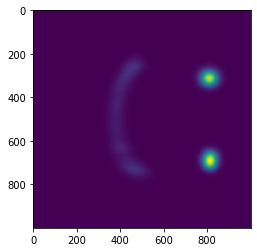

In [164]:
output = model(torch.from_numpy(two_dim).float()).detach().numpy().reshape(1000, 1000)
plt.imshow(output)

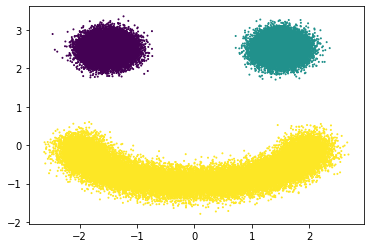

In [173]:
x, y = sample_data()
visualize_data(x, y)

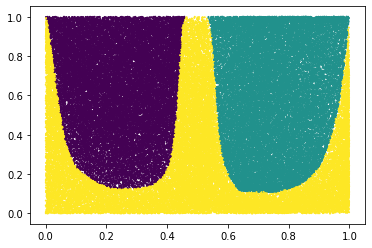

In [171]:
z1, z2 = model.to_latent(x_train.float())
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()
x = np.column_stack((z1, z2))
visualize_data(x, y_train)

In [0]:
class RealNVP(nn.Module):
  def __init__(self, k=6, hidden_size=100):
    super(RealNVP, self).__init__()

    self.sigmoid = nn.Sigmoid()
    self.k = k
    self.layers_1 = []
    self.layers_2 = []
    for _ in range(k):
      self.layers_1.append(nn.Sequential(nn.Linear(2, hidden_size),
                                         nn.ReLU(),
                                         nn.Linear(hidden_size, hidden_size),
                                         nn.ReLU(),
                                         nn.Linear(hidden_size, 2)))
      
      self.layers_2.append(nn.Sequential(nn.Linear(2, hidden_size),
                                         nn.ReLU(),
                                         nn.Linear(hidden_size, hidden_size),
                                         nn.ReLU(),
                                         nn.Linear(hidden_size, 2)),
                                         nn.ReLU())
      self.mask = torch.tensor([[0, 1]]).float()

  def forward(self, x):
    logdet = torch.zeros(x.shape[0], 1).float()
    z = x

    for i in range(self.k):
      z_mask = self.mask * z
      mask = 1 - mask
      l1 = self.layers_1[i](z_mask) * mask
      l2 = self.layers_2[i](z_mask) * mask
      z = z_mask + mask * (z * torch.exp(l2) + l1)
      logdet += l2.sum(dim=1)
    
    return z, logdet

  def to_latent(self, x):
    x = z
    for i in reversed(range(self.k)):
      x_mask = self.mask * x
      mask = 1 - mask
      l1 = self.layers_1[i](x_mask) * mask
      l2 = self.layers_2[i](x_mask) * mask
      x = mask * (x - l1) * torch.exp(-l2) + x_mask
    
    return x